# Import

In [1]:
import sys
import os
from datetime import datetime

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = True
out_dir = '../../out/distributions/ml_100k/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset

In [3]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

In [4]:
print(f'n_user = {n_user}')
print(f'n_item = {n_item}')
print(f'n_feedback = {n_feedback}')

n_user = 940
n_item = 1447
n_feedback = 55369


# Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [6]:
print(device)

cuda:0


# Evaluator

In [7]:
# The size of recommendation set (K)
ks = [10]

score_function_dict = {
    "Recall"       : evaluators.recall,
    "Unpopularity" : evaluators.unpopularity,
    "Serendipity"  : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)

# Sampler

In [8]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [9]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Training

In [10]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [11]:
knn = searches.NearestNeighborhood(model)

In [12]:
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()

In [13]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(out_dir + file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.575893,30.463636,7.285613,0.180426


# MPCMP

In [14]:
# Hyperparameters
n_sample = 100
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gaussian = distributions.Gaussian()
gamma = distributions.Gamma()

In [15]:
rows_1 = []
rows_2 = []
for bias in bias_li:
    print(f'Prosessing... [bias = {bias}]')
    
    mp_1 = searches.MutualProximity(model, gaussian, n_sample, bias)
    mp_2 = searches.MutualProximity(model, gamma, n_sample, bias)
    
    trainer.valid(mp_1, userwise)
    row_1 = trainer.valid_scores.copy()
    trainer.valid(mp_2, userwise)
    row_2 = trainer.valid_scores.copy()
    
    row_1.insert(0, 'Bias', bias)
    row_2.insert(0, 'Bias', bias)
    
    rows_1.append(row_1)
    rows_2.append(row_2)

re_mpcml_1 = pd.concat(rows_1)
re_mpcml_2 = pd.concat(rows_2)

Prosessing... [bias = 0.0]
Prosessing... [bias = 0.1]
Prosessing... [bias = 0.2]
Prosessing... [bias = 0.3]
Prosessing... [bias = 0.4]
Prosessing... [bias = 0.5]
Prosessing... [bias = 0.6]
Prosessing... [bias = 0.7]
Prosessing... [bias = 0.8]
Prosessing... [bias = 0.9]
Prosessing... [bias = 1.0]


In [16]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias1_%Y_%m_%d_%H%M.csv")
    re_mpcml_1.to_csv(out_dir + file_name, index=False)

display(re_mpcml_1)

,Bias,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.0,0.214334,322.883636,3.955871,0.785426
0,0.1,0.472617,67.144066,8.923999,0.440319
0,0.2,0.481900,63.196488,8.984543,0.427021
0,0.3,0.487007,60.067519,8.821701,0.417766
0,0.4,0.490395,58.514494,8.763161,0.403298
0,0.5,0.495971,56.291748,8.807369,0.394787
0,0.6,0.493653,54.833224,8.649818,0.390851
0,0.7,0.500065,53.446794,8.721561,0.383085
0,0.8,0.502741,50.751652,8.648826,0.370106
0,0.9,0.508267,47.220047,8.556258,0.353723


In [17]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias2_%Y_%m_%d_%H%M.csv")
    re_mpcml_2.to_csv(out_dir + file_name, index=False)

display(re_mpcml_2)

,Bias,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.0,0.373465,193.994584,10.239504,0.622872
0,0.1,0.418784,129.142674,10.145682,0.545851
0,0.2,0.446479,102.529901,9.798120,0.500532
0,0.3,0.465119,87.034796,9.592021,0.455638
0,0.4,0.484186,74.354560,9.286324,0.422340
0,0.5,0.502152,63.437939,9.103775,0.387660
0,0.6,0.517847,55.809729,8.789247,0.352979
0,0.7,0.532347,48.564019,8.655069,0.316809
0,0.8,0.546224,42.289559,8.292458,0.279362
0,0.9,0.558057,36.241325,8.019227,0.238936


## CML vs MPCML

In [25]:
# df -> list

k = 10
n_bias = len(bias_li)

# CML(Base)
recall_base           = re_base[f'Recall@{k}'].tolist() * n_bias
unpopularity_base     = re_base[f'Unpopularity@{k}'].tolist() * n_bias
serendipity_base      = re_base[f'Serendipity@{k}'].tolist() * n_bias
longtale_base         = re_base[f'Long-tail rate@{k}'].tolist() * n_bias

# MPCML (Gaussian)
recall_mpcml_1        = re_mpcml_1[f'Recall@{k}'].tolist()
unpopularity_mpcml_1  = re_mpcml_1[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_1   = re_mpcml_1[f'Serendipity@{k}'].tolist()
longtale_mpcml_1      = re_mpcml_1[f'Long-tail rate@{k}'].tolist()

# MPCML (Gamma)
recall_mpcml_2        = re_mpcml_2[f'Recall@{k}'].tolist()
unpopularity_mpcml_2  = re_mpcml_2[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_2   = re_mpcml_2[f'Serendipity@{k}'].tolist()
longtale_mpcml_2      = re_mpcml_2[f'Long-tail rate@{k}'].tolist()

### Recall

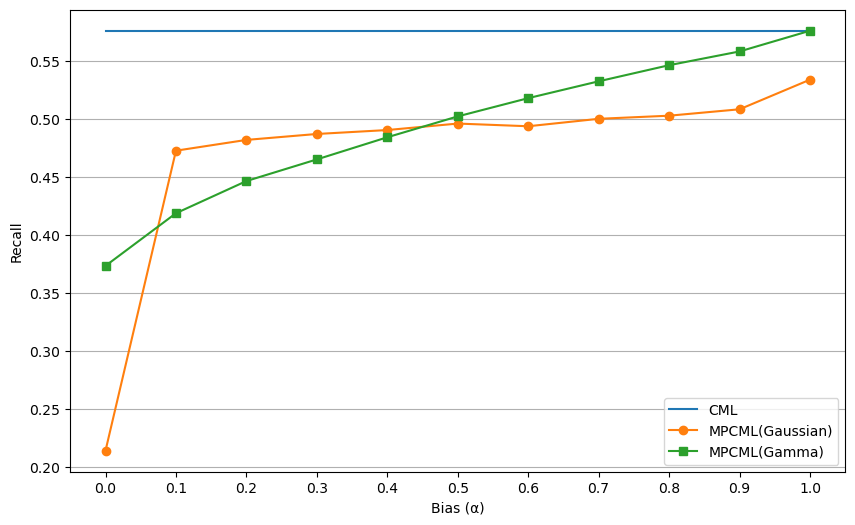

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(bias_li, recall_base, label='CML')
plt.plot(bias_li, recall_mpcml_1, label='MPCML(Gaussian)', marker='o')
plt.plot(bias_li, recall_mpcml_2, label='MPCML(Gamma)', marker='s')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Recall')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("recall_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Unpopularity

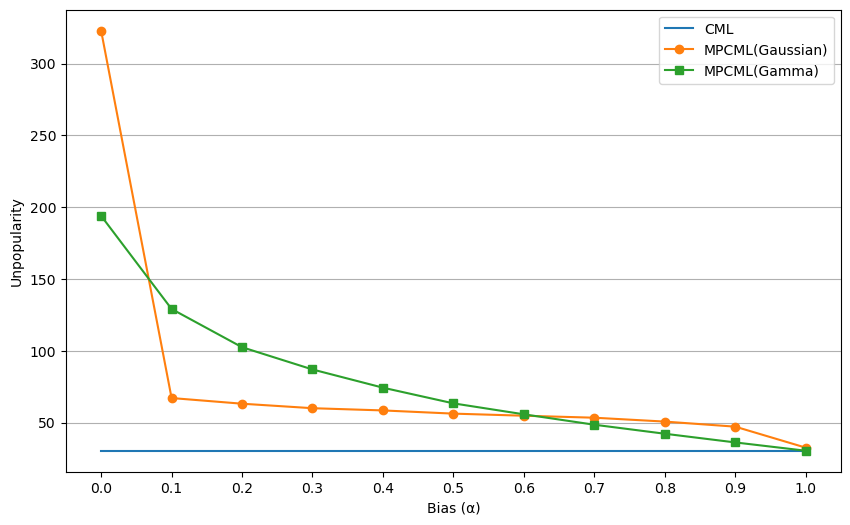

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(bias_li, unpopularity_base, label='CML')
plt.plot(bias_li, unpopularity_mpcml_1, label='MPCML(Gaussian)', marker='o')
plt.plot(bias_li, unpopularity_mpcml_2, label='MPCML(Gamma)', marker='s')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Unpopularity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("unpopularity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

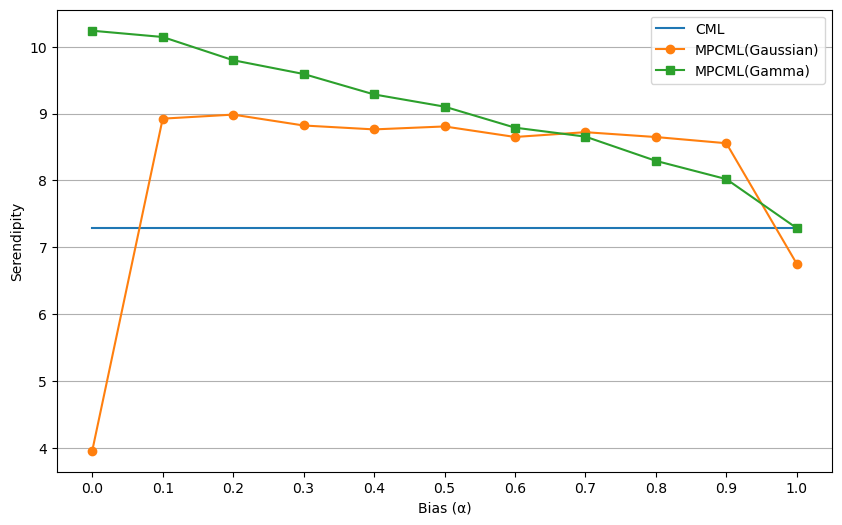

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(bias_li, serendipity_base, label='CML')
plt.plot(bias_li, serendipity_mpcml_1, label='MPCML(Gaussian)', marker='o')
plt.plot(bias_li, serendipity_mpcml_2, label='MPCML(Gamma)', marker='s')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

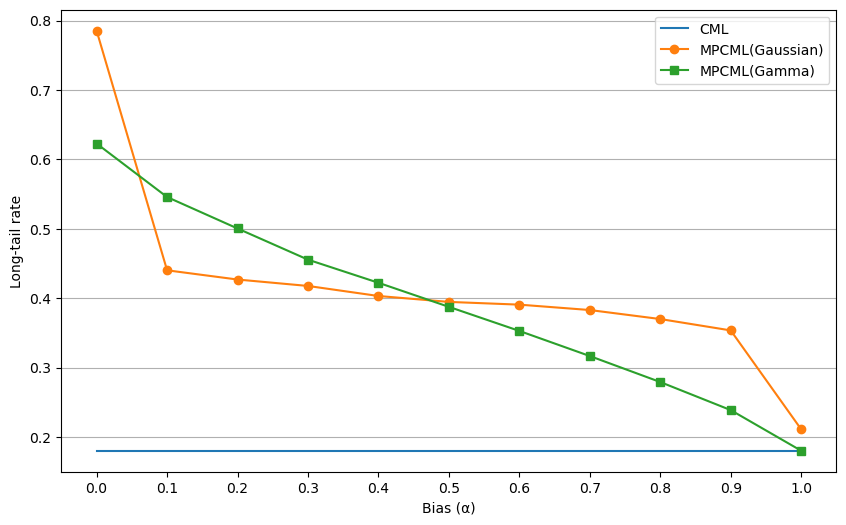

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(bias_li, longtale_base, label='CML')
plt.plot(bias_li, longtale_mpcml_1, label='MPCML(Gaussian)', marker='o')
plt.plot(bias_li, longtale_mpcml_2, label='MPCML(Gamma)', marker='s')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()